# <Center>* Telcome Customer Churn * </Center>

In [ ]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# libraries modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier

In [ ]:
# DATA PREPARATION
df = pd.read_csv("Telecome.csv")
df = df.drop(columns=['CustomerID'], errors='ignore')
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0, 'True': 1, 'False': 0, 1: 1, 0: 0})

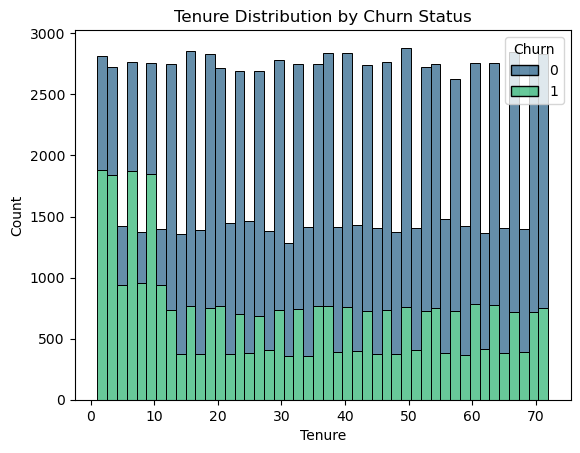

In [ ]:
sns.histplot(data=df, x='Tenure', hue='Churn', multiple='stack', palette='viridis')
plt.title('Tenure Distribution by Churn Status')
plt.show()

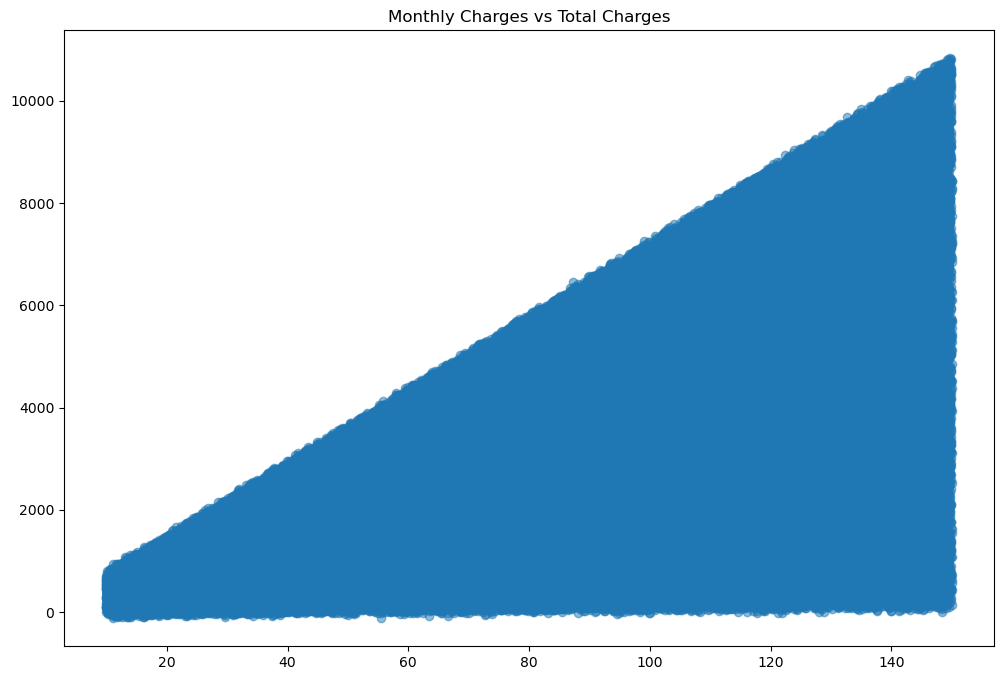

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(df['MonthlyCharges'], df['TotalCharges'], 'o', alpha=0.5)
plt.title('Monthly Charges vs Total Charges')
plt.show()

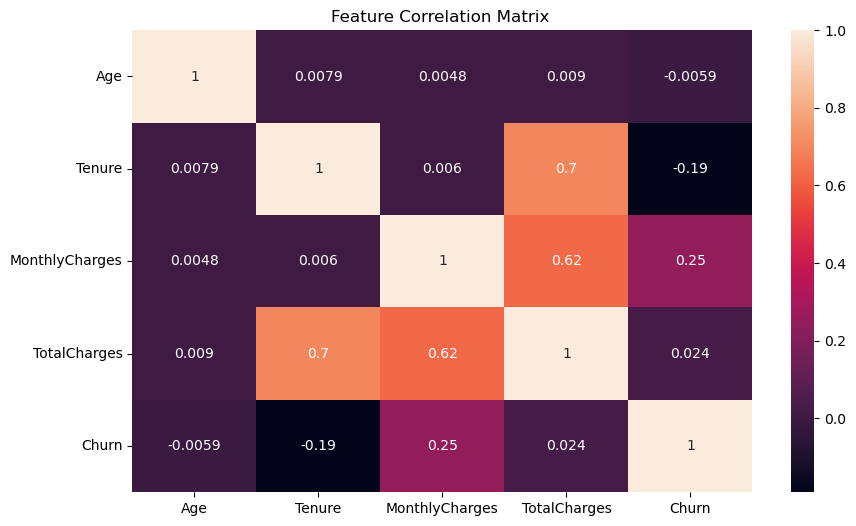

In [ ]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True)
plt.title('Feature Correlation Matrix ')
plt.show()

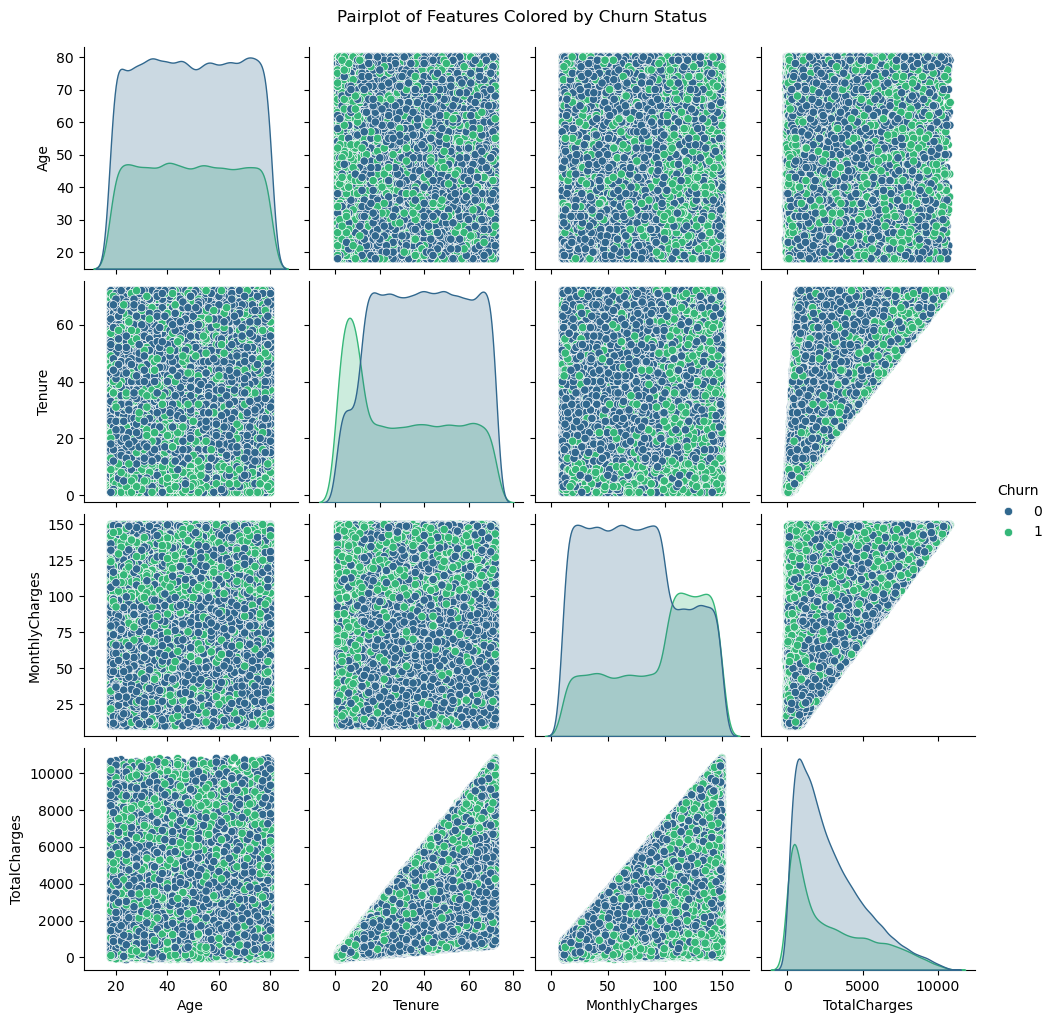

In [ ]:
sns.pairplot(df, hue='Churn', palette='viridis')
plt.suptitle('Pairplot of Features Colored by Churn Status', y=1.02)
plt.show()

In [ ]:
# Encode categorical variables
X = pd.get_dummies(df.drop(columns=['Churn']), drop_first=True)
y = df['Churn'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale data (Essential for Models 1, 2, and 3)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

results = []

def log_result(name, y_true, y_pred):
    results.append({
        "Model": name,
        "Accuracy": f"{accuracy_score(y_true, y_pred):.4f}",
        "Precision": f"{precision_score(y_true, y_pred):.4f}",
        "Recall": f"{recall_score(y_true, y_pred):.4f}",
        "F1-Score": f"{f1_score(y_true, y_pred):.4f}"
    })

# --- MODEL 1: Logistic Regression ---
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train_scaled, y_train)
log_result("Model-1: Logistic Regression", y_test, model_lr.predict(X_test_scaled))

# --- MODEL 2: Torch Model ---
X_train_t = torch.FloatTensor(X_train_scaled)
y_train_t = torch.FloatTensor(y_train).reshape(-1, 1)
X_test_t = torch.FloatTensor(X_test_scaled)

class TorchChurnNet(nn.Module):
    def __init__(self, input_dim):
        super(TorchChurnNet, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x): return self.layer(x)

t_model = TorchChurnNet(X_train_scaled.shape[1])
optimizer = optim.Adam(t_model.parameters(), lr=0.01)
criterion = nn.BCELoss()

for epoch in range(100):
    optimizer.zero_grad()
    loss = criterion(t_model(X_train_t), y_train_t)
    loss.backward()
    optimizer.step()

with torch.no_grad():
    t_preds = (t_model(X_test_t) > 0.5).numpy().astype(int)
    log_result("Model-2: Torch Churn Model", y_test, t_preds)

# --- MODEL 3: MLP Model (Sklearn) ---
model_mlp = MLPClassifier(hidden_layer_sizes=( 64, 32), max_iter=500,)
model_mlp.fit(X_train_scaled, y_train)
log_result("Model-3: MLP Model", y_test, model_mlp.predict(X_test_scaled))

# --- MODEL 4: LightGBM Model ---
model_lgbm = LGBMClassifier(n_estimators=100, learning_rate=0.05, random_state=42, verbose=-1)
model_lgbm.fit(X_train_scaled, y_train)
log_result("Model-4: LightGBM Model", y_test, model_lgbm.predict(X_test_scaled))

# 2. PRINT COMPARISON TABLE
results_df = pd.DataFrame(results)
print("\n" + results_df.to_markdown(index=False))


| Model                        |   Accuracy |   Precision |   Recall |   F1-Score |
|:-----------------------------|-----------:|------------:|---------:|-----------:|
| Model-1: Logistic Regression |     0.7234 |      0.608  |   0.4658 |     0.5275 |
| Model-2: Torch Churn Model   |     0.7471 |      0.6547 |   0.5014 |     0.5679 |
| Model-3: MLP Model           |     0.7563 |      0.6441 |   0.5916 |     0.6168 |
| Model-4: LightGBM Model      |     0.7624 |      0.67   |   0.5579 |     0.6088 |


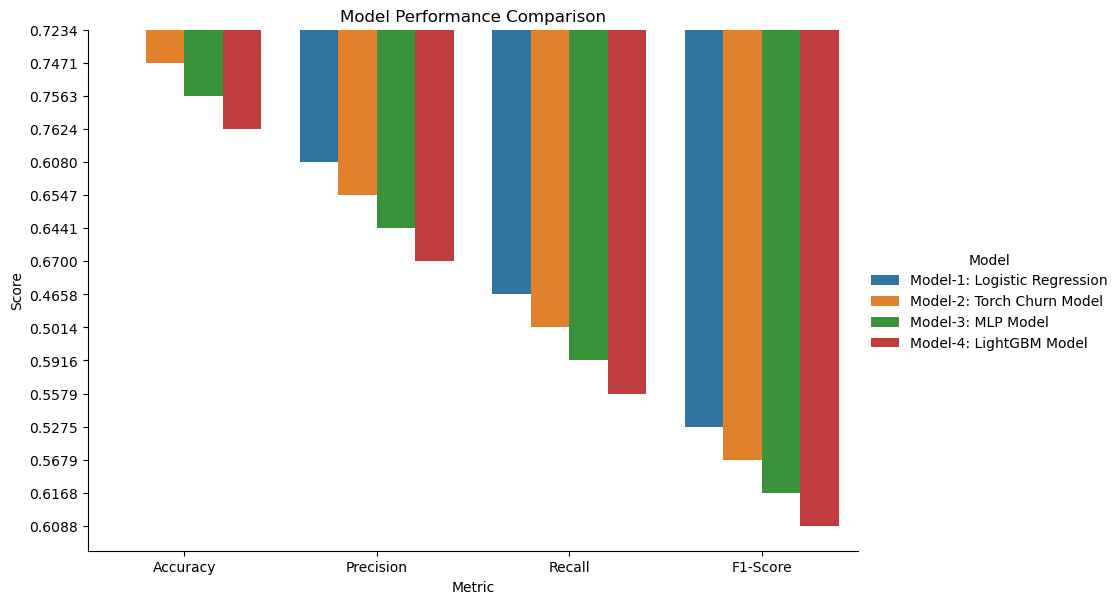

In [ ]:
sns.catplot(data=results_df.melt(id_vars=["Model"], var_name="Metric", value_name="Score"), x="Metric", y="Score", hue="Model", kind="bar", height=6, aspect=1.5)
plt.title("Model Performance Comparison")
plt.show()


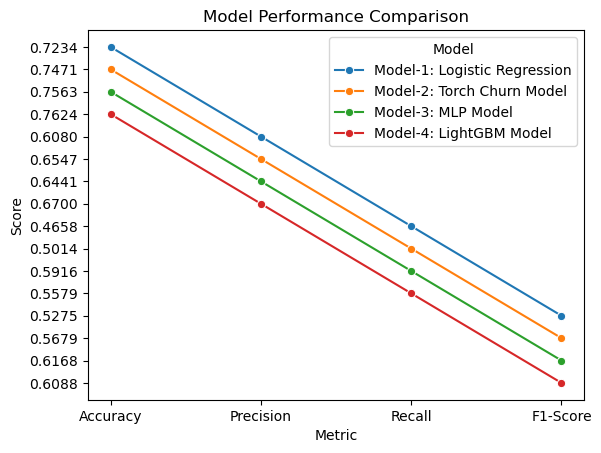

In [ ]:
sns.lineplot(data=results_df.melt(id_vars=["Model"], var_name="Metric", value_name="Score"), x="F1-Score", y="Accuracy", hue="Model", marker="o")
plt.title("Model Performance Comparison")  
plt.show()